# Notebook Binance API - Popoche

**API Key:**
e5cbzLqTXfuF9L4EPkbUpWEl5oUr3GJ4rkGyoicPbCuriA1Zamdpo8niREp0Wcma

**Secret:**
X6Xp3hb9esXZeED55mDARrFHhpDaNBunKTOfBQCrYcbgLUPEsgLHt2fNalDrn9mT

https://python-binance.readthedocs.io/en/latest/account.html#account

** Table**
1. Connection to Binance API

**1. Connection to Binance API**

In [1]:
api_key= "e5cbzLqTXfuF9L4EPkbUpWEl5oUr3GJ4rkGyoicPbCuriA1Zamdpo8niREp0Wcma"
api_secret= "X6Xp3hb9esXZeED55mDARrFHhpDaNBunKTOfBQCrYcbgLUPEsgLHt2fNalDrn9mT"
from binance.client import Client
client = Client(api_key, api_secret)

**2. Preparation de la matrice**

In [2]:
import pandas as pd
import numpy as np
import datetime
from stockstats import StockDataFrame
import matplotlib.pyplot as plt

In [3]:
titre="ONTBTC"
duration="15m"
since="5 day ago UTC"
klines = client.get_historical_klines(titre, duration, since)
df=pd.DataFrame(klines)
df2=df.drop([1,6,7,8,9,10,11], axis=1)
df2.columns=['datetime', 'max', 'min', 'close', 'volume']
df2.datetime[0] = datetime.datetime.fromtimestamp(int(df2.datetime[0]/1000)).strftime('%Y-%m-%d %H:%M')
for i in range (1, len(df2)):
    date_select = datetime.datetime.strptime(df2.datetime[i-1],'%Y-%m-%d %H:%M')
    delta = datetime.timedelta(minutes=1)
    target_date = date_select + delta
    res=target_date.strftime('%Y-%m-%d %H:%M')
    df2.datetime[i]=res

#calcul macd
stock = StockDataFrame.retype(df2)
stock['macd'] = stock.get('macd') # calculate MACD

##calcul rsi
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
         pd.stats.moments.ewma(d, com=period-1, adjust=False)
    return 100 - 100 / (1 + rs)
data = []
for i in range(0,len(stock)):
    data.append(float(stock.close[i]))
data = pd.Series(data)
stock['my_rsi']= RSI( data, 14)

   
df2.head()

/Users/vanessa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vanessa/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


AttributeError: module 'pandas' has no attribute 'stats'

** 3. Recommendation selon stratégie **

In [271]:
##method 1 : trouvée sur le net
signal = stock['macds']       # Your signal line
macd   = stock['macd']        # The MACD that need to cross the signal line
#                                              to give you a Buy/Sell signal
listLongShort = [0]   # Since you need at least two days in the for loop

for i in range(1, len(signal)):
   #                          # If the MACD crosses the signal line upward
   if macd[i] > signal[i] and macd[i -1] <= signal[i -1]:
        listLongShort.append(1)
   #                          # The other way around
   elif macd[i] < signal[i] and macd[i -1] >= signal[i -1]:
        listLongShort.append(0)
   #                          # Do nothing if not crossed
   else:
        listLongShort.append(listLongShort[i-1])

stock['advice'] = listLongShort

In [272]:
## method 2
delta=stock.macd-stock.macds
reco=[0]
for i in range (1, len(stock)):
    if delta[i]-delta[i-1]>0:
        reco.append(1)
    else:
        reco.append(0)
stock['advice'] = reco

In [31]:
## method 3   <=  En cours  juste basee sur le signal  _ RSI<80
delta=stock.macds
reco=[0]
for i in range (1, len(stock)):
    if delta[i]-delta[i-1]>0:
        if stock.my_rsi[i]<80:
            reco.append(1)
        else:
            reco.append(0)
    else:
        reco.append(0)
stock['advice'] = reco

** 4. Calcul des gains **

In [32]:
#calculs gains selon advice
consigne = stock['advice']
close=stock['close']
s_eth=[100]
s_ven=[0]
s_achat=[0]
s_vente=[0]
s_var2=[0]
for i in range(1,len(stock)):
    if (consigne[i]-consigne[i-1])==1:
        s_ven.append(s_eth[i-1]/float(close[i]))
        s_eth.append(0)
        s_achat.append(float(close[i]))
        s_vente.append(0)
        s_var2.append(s_var2[i-1])
    if (consigne[i]-consigne[i-1])==-1:
        s_eth.append(s_ven[i-1]*float(close[i]))
        s_ven.append(0)
        s_achat.append(0)
        s_vente.append(float(close[i]))
        s_var2.append(float(s_eth[i])-100)
    if (consigne[i]-consigne[i-1])==0: 
        s_ven.append(s_ven[i-1])
        s_eth.append(s_eth[i-1])
        s_achat.append(0)
        s_vente.append(0)
        s_var2.append(s_var2[i-1])
stock['var1'] =s_var2

** 5. Raffinage de la recommendation **

In [33]:
# moyenne s_var pour preparation raffine =>32?
import numpy as np
def calcSma(data, smaPeriod):
    j = next(i for i, x in enumerate(data) if x is not None)
    our_range = range(len(data))[j + smaPeriod - 1:]
    empty_list = [None] * (j + smaPeriod - 1)
    sub_result = [np.mean(data[i - smaPeriod + 1: i + 1]) for i in our_range]
    return np.array(empty_list + sub_result)
s_var3=calcSma(s_var2, 3)

In [34]:
#raffine
reco_ref=[0]
for i in range (1, len (stock)):
    if s_var3[i]==None:
        reco_ref.append(0)
        s_var3[i]=0
    elif float(s_var3[i])>float(s_var3[i-1]):
        reco_ref.append(1)
    else:
        reco_ref.append(0)
stock['advice2'] =reco_ref

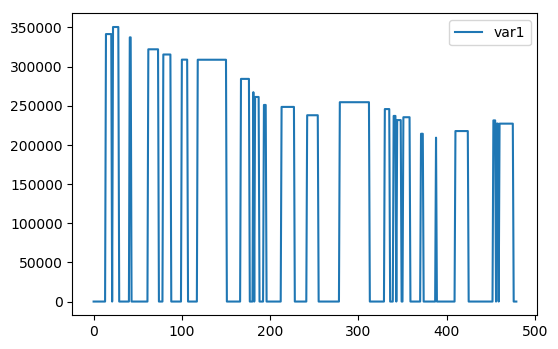

In [35]:
fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(s_ven, label='var1')
#plt.plot(s_var3, label='var2')
plt.legend()
plt.show()

** 6. Calculs des gains bis **

In [36]:
#calcule reco bis
consigne = reco_ref
close=stock['close']
s_eth=[100]
s_ven=[0]
s_var2=[0]
for i in range(1,len(stock)):
    if (consigne[i]-consigne[i-1])==1:
        s_ven.append(s_eth[i-1]/float(close[i]))
        s_eth.append(0)
        s_var2.append(s_var2[i-1])
    if (consigne[i]-consigne[i-1])==-1:
        s_eth.append(s_ven[i-1]*float(close[i]))
        s_ven.append(0)
        s_var2.append(float(s_eth[i])-100)
    if (consigne[i]-consigne[i-1])==0: 
        s_ven.append(s_ven[i-1])
        s_eth.append(s_eth[i-1])
        s_var2.append(s_var2[i-1])
stock['var2'] =s_var2

In [37]:
stock.head()

,datetime,max,min,close,volume,close_12_ema,close_26_ema,macd,macds,macdh,my_rsi,advice,var1,advice2,var2
0,2018-04-03 13:30,0.00029279,0.00029100,0.00029160,17273.00000000,0.000292,0.000292,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0,0.0,0,0.0
1,2018-04-03 13:31,0.00029388,0.00029160,0.00029308,15403.00000000,0.000292,0.000292,3.320513e-08,1.844729e-08,2.951567e-08,NaN,0,0.0,0,0.0
2,2018-04-03 13:32,0.00029500,0.00029288,0.00029355,30061.00000000,0.000293,0.000293,5.688460e-08,3.420029e-08,4.536862e-08,NaN,0,0.0,0,0.0
3,2018-04-03 13:33,0.00029397,0.00029200,0.00029280,26622.00000000,0.000293,0.000293,3.918192e-08,3.588783e-08,6.588178e-09,NaN,0,0.0,0,0.0
4,2018-04-03 13:34,0.00029301,0.00029170,0.00029200,18157.00000000,0.000293,0.000293,-3.096167e-09,2.429097e-08,-5.477428e-08,NaN,0,0.0,0,0.0


** 7. Rendu **

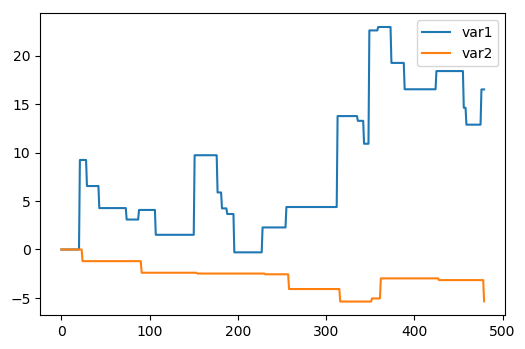

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(stock.var1, label='var1')
plt.plot(stock.var2, label='var2')
plt.legend()
plt.show()

In [29]:
#plt.plot(stock.close)
#plt.show()

In [30]:
stock.var2.mean()

-1.034205603689154

In [31]:
#verification de l'intérêt de la reco
var_hold=100/float(stock.close[0])*float(stock.close[len(stock)-1])-100
var_reco1=stock.var1[len(stock)-1]
var_reco2=stock.var2[len(stock)-1]
print(var_hold)
print(var_reco1)
print(var_reco2)

-1.021956716749017
-3.63239249415
-1.68264060294


** 8. Diverses analyses **

In [32]:
myres=[]
myres2=[]
for i in range (0, len(stock.close)):
    myres.append(float(stock.close[i])*float(stock.advice[i]))
    myres2.append(float(stock.close[i])*float(stock.advice2[i]))

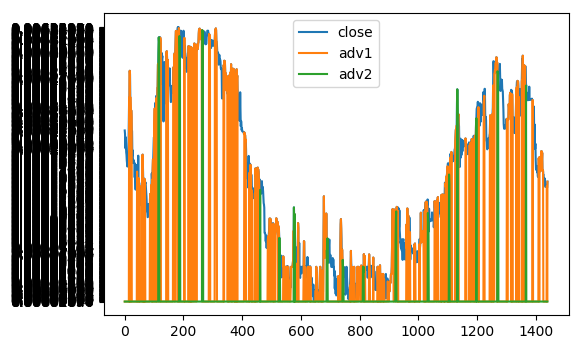

In [33]:
fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(stock.close, label='close')
plt.plot(myres, label='adv1')
plt.plot(myres2, label='adv2')
plt.legend()
plt.figure(figsize=(200,100))
plt.show()

In [34]:
print(len(stock.datetime))
print(len(myres))


1440
1440


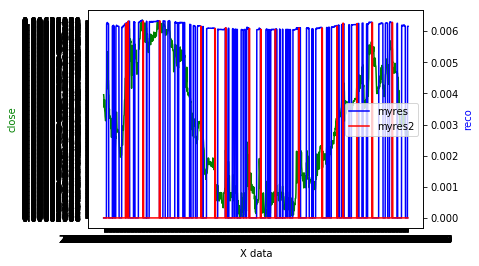

In [35]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(stock.datetime, stock.close, 'g-')
ax2.plot(stock.datetime, myres, 'b-', label='myres')
ax2.plot(stock.datetime, myres2, 'r-', label='myres2')
ax2.legend()
ax1.set_xlabel('X data')
ax1.set_ylabel('close', color='g')
ax2.set_ylabel('reco', color='b')

plt.show()

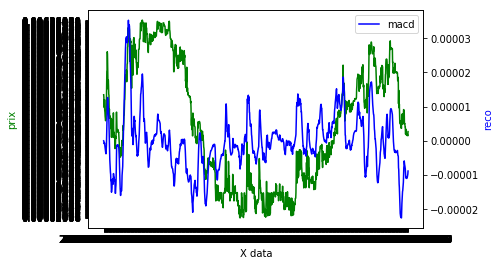

In [39]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(stock.datetime, stock.close, 'g-')
ax2.plot(stock.datetime, stock.macd, 'b-', label='macd')
#ax2.plot(stock.datetime, stock.my_rsi, 'r-', label='rsi')
ax2.legend()
ax1.set_xlabel('X data')
ax1.set_ylabel('prix', color='g')
ax2.set_ylabel('reco', color='b')

plt.show()

**8. Reste à faire**

* calculer le nombre de transactions
* tenir compte des frais de change
* identifier les titres rentables (mouvement haussier, volatilité??)
* realiser des achats ventes

**9. Divers brouillons**

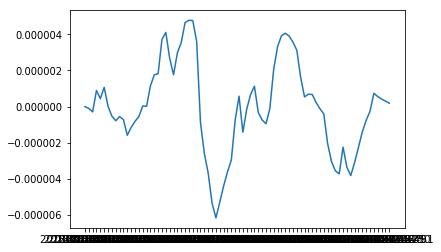

In [323]:
delta=bis.macd-bis.macds
plt.plot(bis.datetime, delta)
#plt.plot(bis.datetime, bis.macds)
plt.show()

In [326]:
reco=[0]
for i in range (1, len(bis)):
    if delta[i]-delta[i-1]>0:
        reco.append(1)
    else:
        reco.append(0)
    

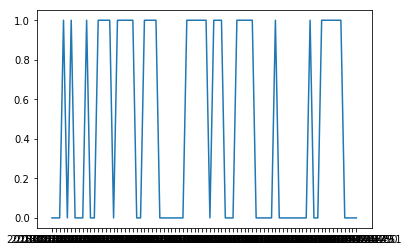

In [327]:
plt.plot(bis.datetime, reco)
plt.show()

In [378]:
stock2 = StockDataFrame.retype(df2)
df2.tail()

,datetime,max,min,close,volume,close_12_ema,close_26_ema,macd,macds,macdh,advice,rsi,close_-1_s
1435,2018-02-03 21:27,0.00584084,0.00582359,0.00584084,466.00000000,0.005842,0.005838,3.499371e-06,0.000007,-0.000007,0,None,0.00584084
1436,2018-02-03 21:28,0.00584084,0.00583494,0.00583494,800.00000000,0.005841,0.005838,2.700431e-06,0.000006,-0.000007,0,None,0.00584084
1437,2018-02-03 21:29,0.00583494,0.00583494,0.00583494,218.00000000,0.005840,0.005838,2.043708e-06,0.000005,-0.000007,0,None,0.00583494
1438,2018-02-03 21:30,0.00583494,0.00583400,0.00583400,11.00000000,0.005839,0.005837,1.430905e-06,0.000005,-0.000006,0,None,0.00583494
1439,2018-02-03 21:31,0.00583400,0.00583400,0.00583400,15.00000000,0.005838,0.005837,9.344822e-07,0.000004,-0.000006,0,None,0.00583400


In [390]:
##calcul rsi
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
         pd.stats.moments.ewma(d, com=period-1, adjust=False)
    return 100 - 100 / (1 + rs)
#sample data from StockCharts
data = []
for i in range(0,len(stock)):
    data.append(float(stock.close[i]))
data = pd.Series(data)
stock['my_rsi']= RSI( data, 14)

/Users/vanessa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=13,min_periods=0,adjust=False,ignore_na=False).mean()
  # This is added back by InteractiveShellApp.init_path()


In [414]:
stock.tail()

,datetime,max,min,close,volume,close_12_ema,close_26_ema,macd,macds,macdh,advice,rsi,close_-1_s,my_rsi
1435,2018-02-03 21:27,0.00584084,0.00582359,0.00584084,466.00000000,0.005842,0.005838,3.499371e-06,0.000007,-0.000007,0,None,0.00584084,51.943017
1436,2018-02-03 21:28,0.00584084,0.00583494,0.00583494,800.00000000,0.005841,0.005838,2.700431e-06,0.000006,-0.000007,0,None,0.00584084,48.434978
1437,2018-02-03 21:29,0.00583494,0.00583494,0.00583494,218.00000000,0.005840,0.005838,2.043708e-06,0.000005,-0.000007,0,None,0.00583494,48.434978
1438,2018-02-03 21:30,0.00583494,0.00583400,0.00583400,11.00000000,0.005839,0.005837,1.430905e-06,0.000005,-0.000006,0,None,0.00583494,47.838004
1439,2018-02-03 21:31,0.00583400,0.00583400,0.00583400,15.00000000,0.005838,0.005837,9.344822e-07,0.000004,-0.000006,0,None,0.00583400,47.838004


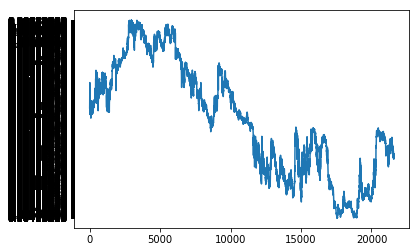

In [546]:
plt.plot(stock.close)
plt.show()

In [300]:
klines = client.get_historical_klines("VENETH", "3m", "5 day ago UTC")

In [4]:
titre="VENETH"
duration="1m"
since="1 day ago UTC"
klines = client.get_historical_klines(titre, duration, since)
df=pd.DataFrame(klines)
df2=df.drop([1,6,7,8,9,10,11], axis=1)
df2.columns=['datetime', 'max', 'min', 'close', 'volume']
df2.datetime[0] = datetime.datetime.fromtimestamp(int(df2.datetime[0]/1000)).strftime('%Y-%m-%d %H:%M')
for i in range (1, len(df2)):
    date_select = datetime.datetime.strptime(df2.datetime[i-1],'%Y-%m-%d %H:%M')
    delta = datetime.timedelta(minutes=1)
    target_date = date_select + delta
    res=target_date.strftime('%Y-%m-%d %H:%M')
    df2.datetime[i]=res

#calcul macd
stock = StockDataFrame.retype(df2)
stock['macd'] = stock.get('macd') # calculate MACD

##calcul rsi
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
         pd.stats.moments.ewma(d, com=period-1, adjust=False)
    return 100 - 100 / (1 + rs)
data = []
for i in range(0,len(stock)):
    data.append(float(stock.close[i]))
data = pd.Series(data)
stock['my_rsi']= RSI( data, 14)

   
stock.to_csv('out2.csv')

/Users/vanessa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vanessa/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/vanessa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=13,min_periods=0,adjust=False,ignore_na=False).mean()


In [4]:
%pip list


The following command must be run outside of the IPython shell:

    $ pip list

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more informations on how to install packages:

    https://docs.python.org/3/installing/
